# 1. Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
from statsmodels.tsa.seasonal import seasonal_decompose
from wordcloud import WordCloud

# 2. Load Dataset

In [2]:
from google.colab import files
files.upload()  # Upload file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wlndry123","key":"24bb146286ff05df734a7584cbfea195"}'}

In [3]:
# Buat folder untuk credential
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d romanfonel/precious-metals-history-since-2000-with-news

Dataset URL: https://www.kaggle.com/datasets/romanfonel/precious-metals-history-since-2000-with-news
License(s): MIT
  0% 0.00/6.42M [00:00<?, ?B/s]
100% 6.42M/6.42M [00:00<00:00, 849MB/s]


In [5]:
with zipfile.ZipFile('precious-metals-history-since-2000-with-news.zip', 'r') as zip_ref:
    zip_ref.extractall('commodity_data')

In [6]:
gold = pd.read_csv('commodity_data/final_gold_data.csv', sep=None, engine='python')
silver = pd.read_csv('commodity_data/final_silver_data.csv', sep=None, engine='python')
platinum = pd.read_csv('commodity_data/final_platinum_data.csv', sep=None, engine='python')
palladium = pd.read_csv('commodity_data/final_palladium_data.csv', sep=None, engine='python')

#3. Exploratory Data Analysis (EDA)

## a. Menampilkan contoh data

In [7]:
gold

,timestamp,open,high,low,close,volume,currency,unit,headlines
0,2000-08-30,273.9,273.9,273.9,273.9,0,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...
1,2000-08-31,274.8,278.3,274.8,278.3,0,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...
2,2000-09-01,277.0,277.0,277.0,277.0,0,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...
3,2000-09-05,275.8,275.8,275.8,275.8,2,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...
4,2000-09-06,274.2,274.2,274.2,274.2,0,usd,ounce,France Telecom Profit Increases / Locale-Based...
...,...,...,...,...,...,...,...,...,...
6172,2025-04-08,2994.0,3014.5,2968.4,2968.4,3213,usd,ounce,South Korea Announces Emergency Support for Au...
6173,2025-04-09,2965.8,3090.4,2965.8,3056.5,2175,usd,ounce,Inside the Chinese City That Said Cash Rewards...
6174,2025-04-10,3073.9,3167.0,3072.1,3155.2,3456,usd,ounce,Six Dead in Helicopter Crash in Hudson River N...
6175,2025-04-11,3182.1,3235.0,3182.1,3222.2,862,usd,ounce,Spanish Siemens Couple Killed Alongside Childr...


## b. Info dataset

In [8]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6177 non-null   object 
 1   open       6177 non-null   float64
 2   high       6177 non-null   float64
 3   low        6177 non-null   float64
 4   close      6177 non-null   float64
 5   volume     6177 non-null   int64  
 6   currency   6177 non-null   object 
 7   unit       6177 non-null   object 
 8   headlines  6177 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 434.4+ KB


## c. Cek missing values

In [9]:
gold.isnull().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0
volume,0
currency,0
unit,0
headlines,0


## d. Cek missing timestamp

In [10]:
# Konversi kolom 'timestamp' ke format datetime
gold['timestamp'] = pd.to_datetime(gold['timestamp'], errors='coerce')

# Cek apakah ada timestamp yang gagal dikonversi
invalid_dates = gold['timestamp'].isna().sum()
print(f"Jumlah baris dengan timestamp tidak valid: {invalid_dates}")
if invalid_dates > 0:
    print("Contoh baris yang gagal konversi:")
    print(gold[gold['timestamp'].isna()].head())

Jumlah baris dengan timestamp tidak valid: 0


In [11]:
# Salin kolom 'timestamp' ke kolom baru sebelum dijadikan index
gold['timestamp_raw'] = gold['timestamp']

# Urutkan dan set sebagai index
gold = gold.sort_values('timestamp_raw')
gold.set_index('timestamp_raw', inplace=True)

# Cek rentang tanggal
print(f"Rentang tanggal: {gold.index.min()} hingga {gold.index.max()}")

# Cek apakah ada tanggal yang hilang (frekuensi harian)
all_dates = pd.date_range(start=gold.index.min(), end=gold.index.max(), freq='D')
missing_dates = all_dates.difference(gold.index)
print(f"Jumlah tanggal hilang: {len(missing_dates)}")
print("Contoh tanggal hilang:", missing_dates[:5])



Rentang tanggal: 2000-08-30 00:00:00 hingga 2025-04-14 00:00:00
Jumlah tanggal hilang: 2817
Contoh tanggal hilang: DatetimeIndex(['2000-09-02', '2000-09-03', '2000-09-04', '2000-09-09',
               '2000-09-10'],
              dtype='datetime64[ns]', freq=None)


## e. Statistik deskriptif kolom numerik

In [12]:
gold[['open', 'high', 'low', 'close', 'volume']].describe()

,open,high,low,close,volume
count,6177.000000,6177.000000,6177.000000,6177.000000,6177.000000
mean,1181.017241,1186.953392,1174.885090,1181.012304,4298.049377
std,606.257425,609.741360,602.902334,606.424369,24281.911885
min,255.000000,256.100000,255.000000,255.100000,0.000000
25%,636.500000,640.200000,634.000000,635.200000,21.000000
50%,1238.200000,1243.900000,1231.800000,1238.400000,108.000000
75%,1641.300000,1652.200000,1630.400000,1640.300000,415.000000
max,3215.500000,3235.000000,3194.500000,3222.200000,386334.000000


### 📊 **Analisis Statistik**

### 1. Distribusi Harga (`open`, `high`, `low`, `close`)
- **Jumlah data (count):** 6.177 baris valid untuk semua kolom harga dan volume.
- **Rata-rata harga penutupan (`close`):** 1181.01
- **Harga minimum:** 255 (open/low/close)
- **Harga maksimum:** ~3.222
- **Standar deviasi:** sekitar 606–609 untuk semua harga, menandakan **variabilitas harga yang tinggi** sepanjang periode.

### 2. Distribusi Volume
- **Rata-rata volume:** 4.298, tetapi...
- **Standar deviasi tinggi:** 24.281 → menunjukkan adanya **outlier besar**
- **Volume minimum:** 0
- **Volume maksimum:** 386.334
- **Median (Q2):** 108 → sangat kecil dibandingkan rata-rata → **distribusi right-skewed**

### 3. Interkuartil (IQR) Harga
- Harga **Q1 ke Q3** (rentang tengah 50%):
  - `open`: 636.5 – 1641.3
  - `close`: 635.2 – 1640.3
- Ini menunjukkan **kenaikan signifikan harga secara historis**.

---

 ### ✅ **Kesimpulan Utama**

- **Harga logam** dalam dataset menunjukkan **tren kenaikan jangka panjang**, terlihat dari nilai kuartil dan rentang maksimum yang besar.
- **Variasi harga** cukup besar (std > 600), menunjukkan **volatilitas pasar logam mulia**.
- **Distribusi volume perdagangan** sangat tidak merata, dengan mayoritas transaksi berada pada volume kecil namun ada **outlier ekstrem**.
- **Potensi pembersihan data diperlukan**, khususnya pada **volume = 0** dan **outlier besar**, sebelum digunakan untuk **modeling time series**.


## f. Visualisasi tren harga penutupan sepanjang waktu

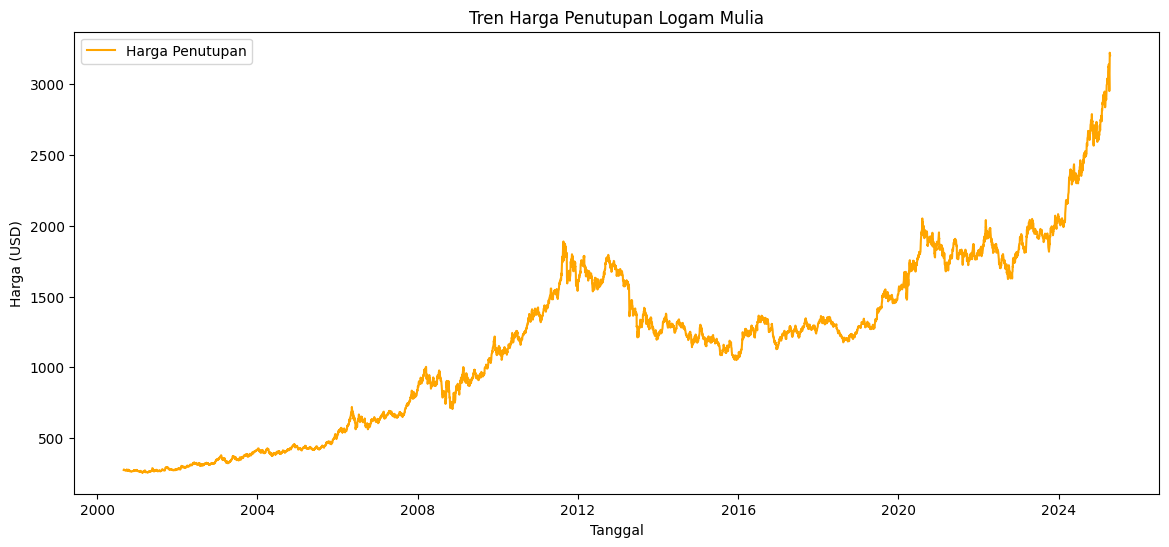

In [16]:
plt.figure(figsize=(14,6))
plt.plot(gold['timestamp'], gold['close'], label='Harga Penutupan', color='orange')
plt.title('Tren Harga Penutupan Logam Mulia')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

### 📊 Analisis Tren Harga Penutupan Logam Mulia (2000–2024)

### 1. 📈 Tren Jangka Panjang
- Harga logam mulia menunjukkan **tren naik signifikan** dari kisaran **$250** pada tahun 2000 hingga mencapai lebih dari **$3.000** pada tahun 2024.
- Kenaikan ini bersifat **eksponensial**, terutama setelah tahun 2019, menandakan peningkatan permintaan atau ketidakstabilan ekonomi global yang memicu minat terhadap aset safe haven seperti logam mulia.

### 2. 🔁 Fase Kenaikan dan Konsolidasi
- **2005–2011:** Periode pertumbuhan tajam, berakhir di puncak sekitar tahun 2011–2012.
- **2013–2018:** Fase konsolidasi dengan harga cenderung sideways (bergerak mendatar).
- **2020–2024:** Tren naik berlanjut dengan lonjakan harga yang curam, kemungkinan dipicu oleh pandemi, inflasi global, atau ketidakpastian geopolitik.

### 3. ⚠️ Volatilitas Harga
- Grafik memperlihatkan **fluktuasi tajam** di beberapa periode:
  - Koreksi signifikan pasca 2012.
  - Fluktuasi tinggi pada periode 2020–2022.
- Hal ini menunjukkan bahwa logam mulia merupakan aset dengan **volatilitas tinggi**, meskipun arah tren jangka panjang tetap naik.

### 4. 🔍 Implikasi untuk Peramalan Time Series
- **Komponen tren kuat** → cocok untuk model seperti ARIMA dengan tren, Prophet, atau LSTM.
- **Musiman tidak terlihat jelas** secara visual, namun perlu dianalisis lebih lanjut menggunakan decomposisi statistik.
- **Volatilitas tinggi dan outlier** perlu ditangani secara khusus, terutama untuk model prediktif.

---

### ✅ Kesimpulan
- Harga logam mulia mengalami **apresiasi jangka panjang yang kuat**, menjadikannya aset menarik untuk investasi jangka panjang.
- Diperlukan **analisis lanjutan terhadap komponen musiman dan anomali data** sebelum dilakukan modeling prediktif.
- Cocok dijadikan objek pemodelan time series, terutama dengan pendekatan yang memperhitungkan tren dan volatilitas pasar.


## g. Visualisasi distribusi return harian

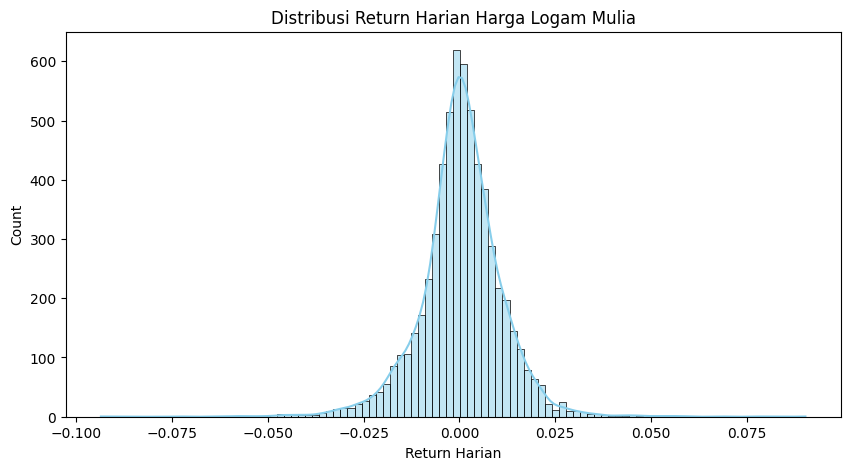

In [18]:
gold['daily_return'] = gold['close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(gold['daily_return'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Distribusi Return Harian Harga Logam Mulia')
plt.xlabel('Return Harian')
plt.show()

In [20]:
gold['daily_return'].describe()

,daily_return
count,6176.000000
mean,0.000457
std,0.010864
min,-0.093538
25%,-0.004716
50%,0.000475
75%,0.006237
max,0.090277


### 📊 Analisis Distribusi Return Harian Harga Logam Mulia

### 1. ⚖️ Bentuk Distribusi
- Distribusi membentuk kurva **mendekati normal (bell-shaped)**.
- Terdapat **ekor tebal (fat tails)** di kiri dan kanan → menunjukkan distribusi **leptokurtik**.
- Artinya, meskipun sebagian besar perubahan harga harian kecil, ada **frekuensi signifikan dari perubahan ekstrem** (baik naik maupun turun).

### 2. 📍 Simetri dan Skewness
- Titik puncak berada sedikit di kanan nol → menunjukkan **sedikit skewness positif**.
- Ini menunjukkan bahwa **kenaikan kecil lebih sering terjadi** daripada penurunan kecil.

### 3. 📈 Implikasi untuk Investor dan Model
- Return harian **tidak sepenuhnya normal**, sehingga model statistik yang mengasumsikan normalitas mungkin **kurang akurat dalam memprediksi risiko ekstrem**.
- Penting untuk mempertimbangkan risiko outlier dalam perencanaan investasi dan pengelolaan risiko.

### ✅ Kesimpulan
Return harian harga logam mulia sebagian besar stabil, tetapi tetap memiliki kemungkinan **fluktuasi ekstrem**, sehingga analisis risiko perlu mempertimbangkan **tail risk**. Distribusi ini mencerminkan **volatilitas pasar yang moderat dengan kecenderungan positif jangka pendek**.


## h. Scatterplot volume vs harga penutupan

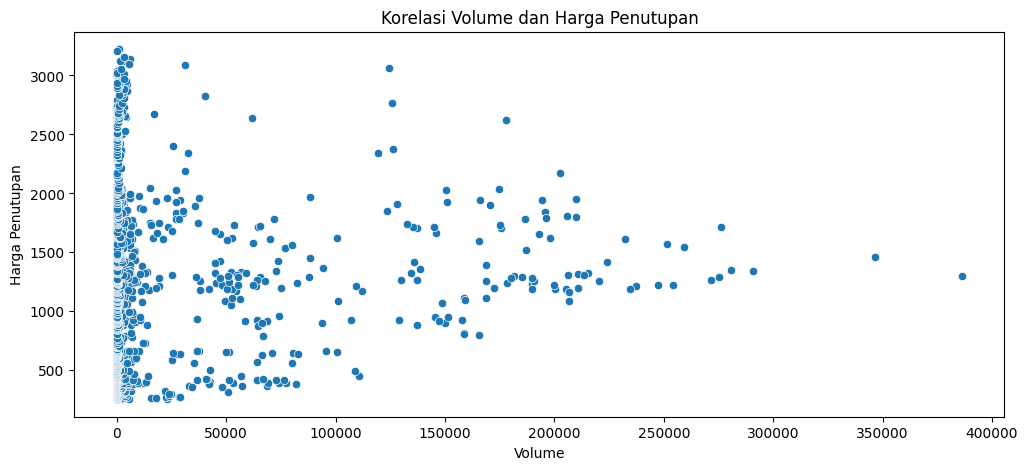

In [23]:
plt.figure(figsize=(12,5))
sns.scatterplot(x='volume', y='close', data=gold)
plt.title('Korelasi Volume dan Harga Penutupan')
plt.xlabel('Volume')
plt.ylabel('Harga Penutupan')
plt.show()

### 📊 Analisis Scatter Plot: Volume vs Harga Penutupan

### 1. Distribusi Data
- Data menunjukkan bahwa sebagian besar volume transaksi berada di bawah **50.000 unit**, dengan konsentrasi titik yang sangat padat di area tersebut.
- Harga penutupan tersebar luas dari sekitar **250** hingga lebih dari **3000**, menunjukkan variasi harga yang besar.

### 2. Korelasi yang Lemah
- Tidak tampak pola linier atau tren yang jelas antara volume dan harga penutupan.
- Titik-titik data tersebar secara **acak dan menyebar horizontal**, tanpa kecenderungan menaik atau menurun.

### 3. Outlier
- Terdapat beberapa **outlier** pada volume yang sangat tinggi (misalnya > 200.000) dan harga penutupan ekstrem.
- Outlier ini tidak serta-merta menunjukkan hubungan sebab akibat antara volume dan harga.

> 🔍 **Korelasi lemah atau mendekati nol** antara volume dan harga penutupan sudah sejalan dengan hasil matriks korelasi sebelumnya (sekitar 0.045).

### ✅ Kesimpulan
- Tidak ada hubungan yang signifikan antara volume dan harga penutupan logam mulia.
- Volume **tidak dapat dijadikan prediktor utama** untuk memodelkan harga penutupan secara linier.
- Untuk eksplorasi lebih lanjut, dapat dipertimbangkan pendekatan non-linier atau melihat variabel lain yang lebih relevan.



## i. Matriks korelasi antar variabel numerik

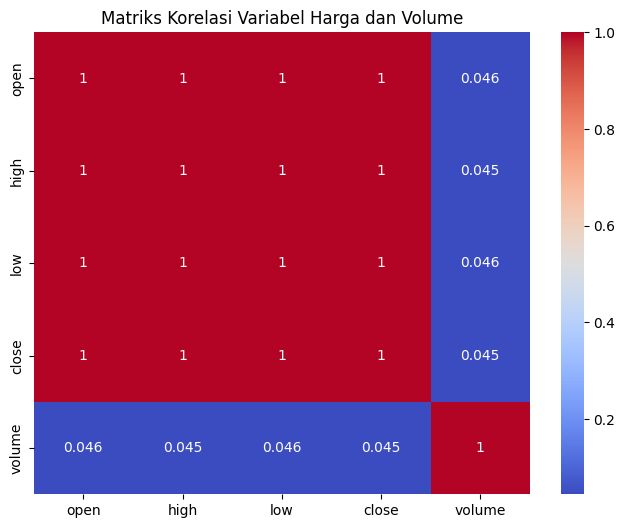

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(gold[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi Variabel Harga dan Volume')
plt.show()

### 🔍 Analisis Matriks Korelasi Variabel Harga dan Volume

### 1. 📈 Korelasi Antar Harga (Open, High, Low, Close)
- Nilai korelasi antara variabel `open`, `high`, `low`, dan `close` adalah **1.0**.
- Ini menunjukkan bahwa keempat harga ini **sangat berkorelasi sempurna** satu sama lain.
- Artinya, pergerakan salah satu jenis harga harian (misalnya harga penutupan) sangat mencerminkan pergerakan jenis harga lainnya.

> 📌 **Implikasi**: Variabel harga ini bersifat **redundan**. Untuk analisis lebih lanjut, cukup memilih satu di antara keempat variabel tersebut.

### 2. 🔄 Korelasi Volume dengan Harga
- Korelasi antara `volume` dan keempat variabel harga berada di sekitar **0.045 – 0.046**, yang sangat **rendah**.
- Ini menunjukkan bahwa **volume perdagangan tidak memiliki hubungan linier yang signifikan** terhadap pergerakan harga.

> 📌 **Implikasi**: Volume dapat dipertimbangkan sebagai **variabel independen** dalam analisis prediktif harga, atau mungkin tidak relevan untuk model linier.

### ✅ Kesimpulan
- Harga `open`, `high`, `low`, dan `close` sangat saling berkorelasi → cukup gunakan satu.
- Volume perdagangan **tidak berkorelasi signifikan** terhadap harga logam mulia.
- Analisis lanjutan mungkin memerlukan pendekatan non-linier jika ingin memanfaatkan volume sebagai fitur prediktif.



## j. Plot boxplot untuk melihat outlier pada harga

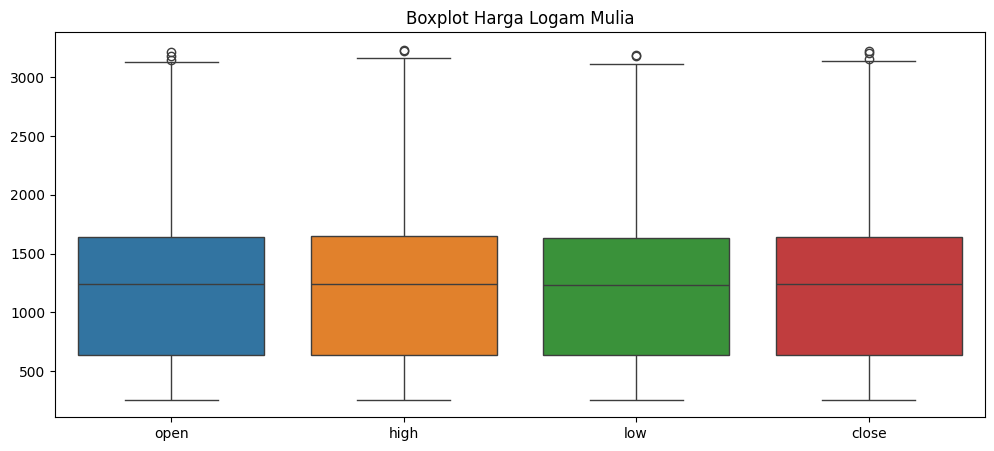

In [26]:
plt.figure(figsize=(12,5))
sns.boxplot(data=gold[['open', 'high', 'low', 'close']])
plt.title('Boxplot Harga Logam Mulia')
plt.show()

### 📦 Analisis Boxplot Harga Logam Mulia

### 1. Persebaran Harga
- Median dari semua variabel harga (`open`, `high`, `low`, `close`) berada di kisaran **1.200–1.300**, menunjukkan nilai tengah yang serupa antar semua jenis harga.
- Rentang interkuartil (IQR: Q3 - Q1) cukup lebar, menandakan **variabilitas harga yang tinggi**.

### 2. Simetri dan Kecenderungan
- Bentuk boxplot cukup simetris, menandakan **distribusi data relatif normal** meskipun terdapat kemiringan kecil pada beberapa harga.

### 3. Outlier
- Semua variabel menunjukkan **keberadaan outlier** yang signifikan, terutama di sisi atas (harga sangat tinggi > 3.000).
- Ini menunjukkan bahwa **ada beberapa hari dengan lonjakan harga yang ekstrem**, namun tidak sering terjadi.

### 4. Kesamaan Pola
- Keempat jenis harga (open, high, low, close) memiliki pola distribusi yang **mirip satu sama lain**, mendukung hasil korelasi sebelumnya yang sangat kuat antar variabel harga (semua korelasi = 1.00).
- Hal ini wajar dalam data pasar karena harga open, high, low, dan close pada satu hari biasanya berada dalam rentang yang berdekatan.

### ✅ Kesimpulan
- Harga logam mulia memiliki distribusi yang seragam antar jenis harga.
- Perlu perhatian khusus terhadap **outlier**, terutama jika ingin menggunakan model statistik atau machine learning yang sensitif terhadap nilai ekstrem (misalnya regresi linear).


## k. Visualisasi volume perdagangan sepanjang waktu

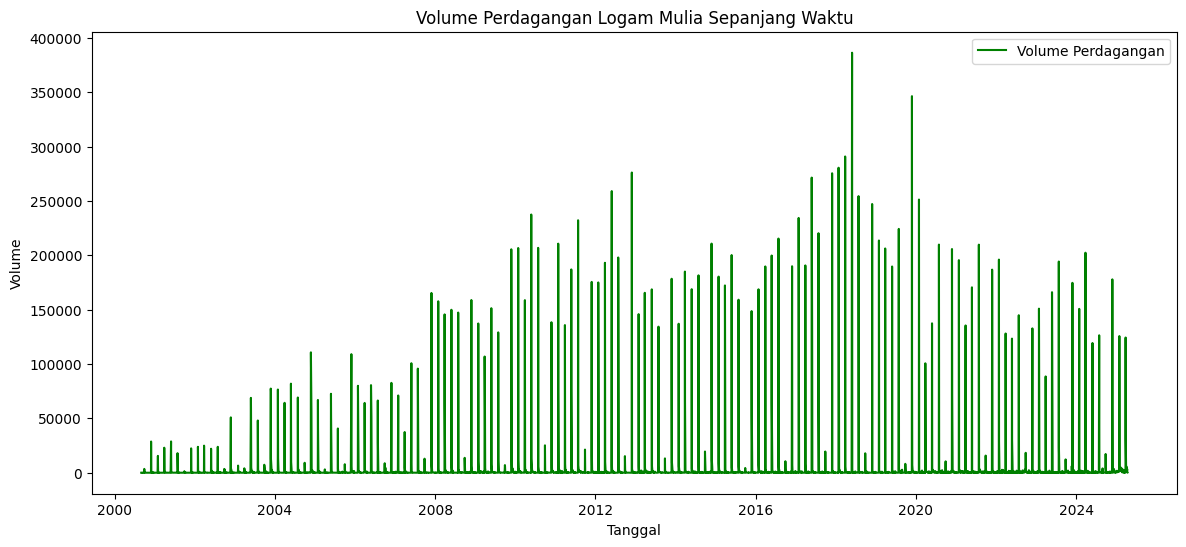

In [28]:
plt.figure(figsize=(14,6))
plt.plot(gold['timestamp'], gold['volume'], label='Volume Perdagangan', color='green')
plt.title('Volume Perdagangan Logam Mulia Sepanjang Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Volume')
plt.legend()
plt.show()

### 📊 Analisis Volume Perdagangan Logam Mulia (2000–2025)

### 1. Tren Umum
- Terjadi **kenaikan volume perdagangan** yang signifikan dari tahun 2000 hingga puncaknya sekitar tahun **2018–2019**.
- Setelah 2019, volume cenderung **menurun** dengan **fluktuasi tinggi**.

### 2. Puncak Aktivitas
- Volume tertinggi terjadi sekitar **2018–2019**, mendekati **400.000 unit transaksi**.
- Peningkatan volume ini bisa dikaitkan dengan:
  - Ketidakpastian ekonomi global (misalnya perang dagang, ketegangan geopolitik).
  - Minat tinggi terhadap logam mulia sebagai **aset lindung nilai (safe haven)**.

### 3. Fluktuasi
- Setelah puncaknya, volume menunjukkan **penurunan drastis** dan **volatilitas tinggi**.
- Periode **2020–2022** menunjukkan volume menurun tajam, kemungkinan dampak dari **pandemi COVID-19** yang memengaruhi pasar global.

### 4. Stabilitas Baru
- Dalam kurun waktu **2023–2025**, volume perdagangan cenderung **lebih stabil**, meski **masih belum setinggi sebelum 2020**.

### 5. Insight Potensial
- Lonjakan volume perdagangan dapat mencerminkan **ketertarikan investor** terhadap logam mulia di tengah ketidakpastian.
- Penurunan volume dapat menunjukkan **pergeseran minat investasi** ke instrumen lain seperti kripto atau saham.

---

### ✅ Kesimpulan
- Volume perdagangan logam mulia tumbuh pesat hingga 2019.
- Terjadi penurunan dan fluktuasi akibat faktor eksternal seperti pandemi.
- Data ini berguna untuk menentukan **waktu ideal investasi** dan memahami **sentimen pasar** terhadap logam mulia.



## l. Analisis harga rata-rata per tahun

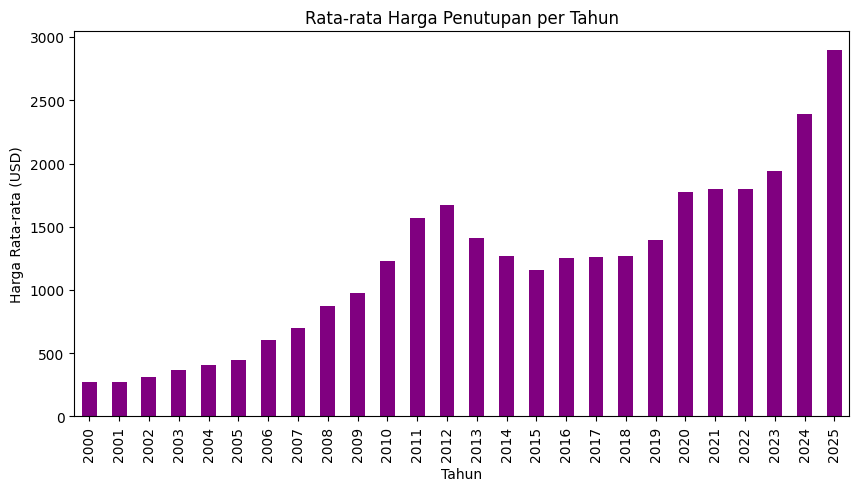

In [43]:
gold['year'] = gold['timestamp'].dt.year
gold['month'] = gold['timestamp'].dt.month

annual_mean = gold.groupby('year')['close'].mean()
plt.figure(figsize=(10,5))
annual_mean.plot(kind='bar', color='purple')
plt.title('Rata-rata Harga Penutupan per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Harga Rata-rata (USD)')
plt.show()

### Analisis Rata-rata Harga Penutupan Logam Mulia per Tahun (2000–2025)

### 1. Trend Kenaikan Harga
- Harga rata-rata penutupan logam mulia meningkat secara signifikan dari sekitar **$270** di tahun 2000 menjadi hampir **$2.900** pada tahun 2025.
- Hal ini menunjukkan pertumbuhan nilai investasi logam mulia dalam jangka panjang.

### 2. Pertumbuhan Stabil di Awal 2000-an
- Pada rentang tahun 2000 hingga 2005, kenaikan harga relatif lambat namun konsisten.
- Pada periode 2006–2012 terjadi kenaikan yang sangat cepat, mencapai puncak di sekitar tahun 2011-2012.

### 3. Penurunan Rata-rata Harga Setelah 2012
- Terjadi penurunan rata-rata harga pada periode 2013 hingga 2018.
- Hal ini kemungkinan terkait koreksi pasar dan stabilisasi harga setelah lonjakan tajam sebelumnya.

### 4. Pemulihan dan Lonjakan Pasca 2019
- Setelah tahun 2019, harga rata-rata mengalami pemulihan kuat dan naik kembali.
- Lonjakan terbesar terjadi antara 2020 hingga 2025 dengan pertumbuhan yang tajam.
- Faktor yang memengaruhi termasuk kondisi ekonomi global, pandemi COVID-19, dan situasi geopolitik.

---

### Kesimpulan
- Harga logam mulia menunjukkan **pertumbuhan jangka panjang yang signifikan**.
- Meskipun terjadi koreksi harga, tren keseluruhan tetap bullish.
- **Investasi logam mulia sangat menjanjikan untuk jangka panjang** dengan potensi keuntungan yang stabil dan berkelanjutan.


## m. Analisis harga rata-rata per bulan (gabungkan semua tahun)

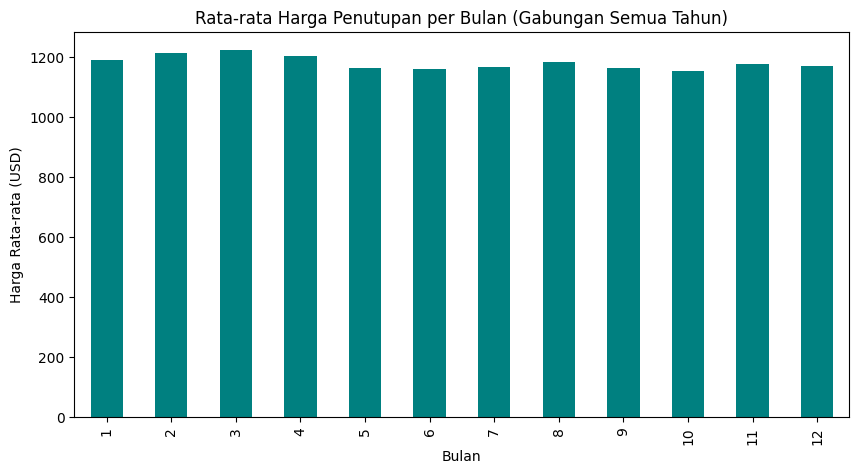

In [44]:
monthly_mean = gold.groupby('month')['close'].mean()
plt.figure(figsize=(10,5))
monthly_mean.plot(kind='bar', color='teal')
plt.title('Rata-rata Harga Penutupan per Bulan (Gabungan Semua Tahun)')
plt.xlabel('Bulan')
plt.ylabel('Harga Rata-rata (USD)')
plt.show()

### Analisis Rata-rata Harga Penutupan Logam Mulia per Bulan (Gabungan Semua Tahun)

### 1. Pola Harga Bulanan
- Harga rata-rata penutupan logam mulia per bulan relatif stabil dengan variasi yang sangat kecil.
- Nilai rata-rata berada di kisaran **1.150 hingga 1.230 USD** sepanjang tahun.

### 2. Bulan dengan Harga Tertinggi
- Bulan Maret (bulan ke-3) menunjukkan harga rata-rata penutupan tertinggi, sekitar **1.225 USD**.
- Bulan Februari juga relatif tinggi, mendekati puncak harga di atas 1.210 USD.

### 3. Bulan dengan Harga Terendah
- Bulan Mei (bulan ke-5) dan Juni (bulan ke-6) menunjukkan harga rata-rata terendah, mendekati **1.160 USD**.
- Ini menunjukkan adanya sedikit penurunan harga di pertengahan tahun.

### 4. Interpretasi
- Fluktuasi harga bulanan yang kecil menunjukkan bahwa **harga logam mulia cenderung stabil dalam skala bulan sepanjang tahun**.
- Tidak ada pola musiman yang kuat terlihat, sehingga investasi jangka pendek dalam satu bulan tertentu tidak menunjukkan perbedaan signifikan.

---

### Kesimpulan
- Harga logam mulia bersifat stabil secara musiman.
- Investor bisa fokus pada tren jangka panjang daripada mencoba memanfaatkan variasi musiman bulanan.


## n. Plot rolling mean dan rolling std (untuk cek stasioneritas)

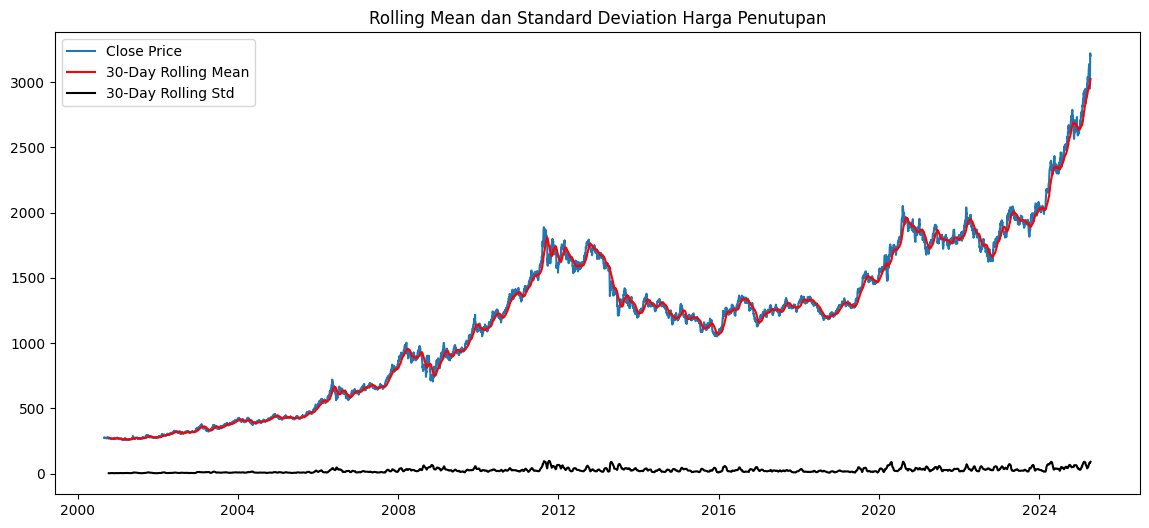

In [35]:
window = 30  # 30 hari
rolling_mean = gold['close'].rolling(window=window).mean()
rolling_std = gold['close'].rolling(window=window).std()

plt.figure(figsize=(14,6))
plt.plot(gold['close'], label='Close Price')
plt.plot(rolling_mean, color='red', label=f'{window}-Day Rolling Mean')
plt.plot(rolling_std, color='black', label=f'{window}-Day Rolling Std')
plt.title('Rolling Mean dan Standard Deviation Harga Penutupan')
plt.legend()
plt.show()

### Analisis Rolling Mean dan Standard Deviation Harga Penutupan Logam Mulia

### 1. Tren Harga Penutupan (Close Price)
- Harga penutupan logam mulia menunjukkan tren naik yang cukup signifikan dari tahun 2000 hingga 2025.
- Terjadi beberapa periode koreksi harga, terutama sekitar tahun 2012 dan 2016, namun tren jangka panjang tetap naik.

### 2. Rolling Mean 30 Hari
- Garis merah yang merepresentasikan rata-rata bergerak (rolling mean) 30 hari mengikuti pergerakan harga penutupan dengan halus.
- Rolling mean menunjukkan smoothing yang membantu melihat tren jangka pendek secara lebih jelas dan mengurangi fluktuasi harian.

### 3. Rolling Standard Deviation 30 Hari
- Garis hitam menunjukkan volatilitas harga (standar deviasi) selama 30 hari.
- Volatilitas cenderung meningkat pada beberapa periode tertentu, terutama:
  - Sekitar tahun 2008-2012, kemungkinan terkait krisis keuangan global.
  - Pada tahun-tahun terakhir menuju 2025, yang menunjukkan ketidakstabilan harga yang lebih tinggi di pasar logam mulia.
- Periode dengan volatilitas rendah menunjukkan fase pasar yang relatif stabil.

### 4. Interpretasi
- Meskipun harga logam mulia mengalami tren kenaikan jangka panjang, ada fluktuasi dan ketidakpastian yang signifikan dalam periode tertentu.
- Investor harus waspada terhadap volatilitas ini karena bisa mempengaruhi risiko investasi.
- Rolling mean dapat digunakan sebagai indikator untuk mengidentifikasi tren harga dan potensi titik balik pasar.

---

### Kesimpulan
- Harga logam mulia naik secara konsisten dalam jangka panjang dengan fluktuasi volatilitas yang bervariasi.
- Penggunaan rolling mean dan rolling standard deviation membantu memahami tren dan risiko pasar secara lebih efektif.


## o. Decompose time series (trend, seasonal, residual)

<Figure size 1400x1000 with 0 Axes>

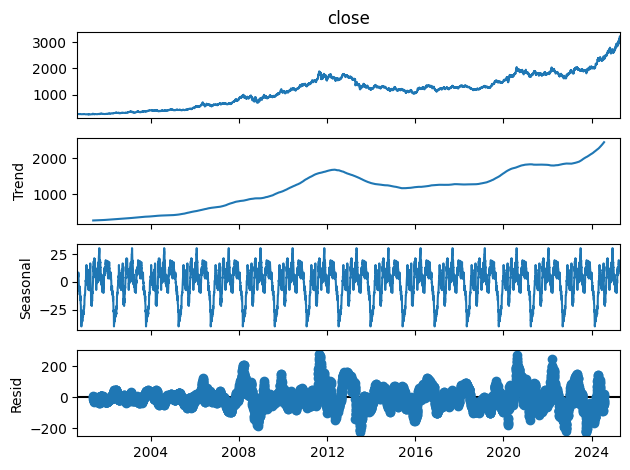

In [45]:
decomposition = seasonal_decompose(gold['close'], model='additive', period=365) # asumsi data harian

plt.figure(figsize=(14,10))
decomposition.plot()
plt.show()

### 📊 Analisis Dekomposisi Deret Waktu Harga Penutupan Logam Mulia

### 1. Tren Harga Jangka Panjang (Trend)
- Komponen tren menunjukkan **kenaikan harga logam mulia yang stabil dari tahun 2000 hingga sekitar 2011**, disusul oleh **fase stagnasi atau penurunan ringan** antara 2012–2018.
- Setelah 2019, **tren naik kembali menguat**, mencerminkan permintaan yang meningkat atau faktor makroekonomi yang mendukung harga logam mulia.

### 2. Pola Musiman (Seasonality)
- Terdapat **pola musiman yang konsisten dan berulang** tiap tahun, dengan amplitudo sekitar ±25 unit.
- Fluktuasi musiman ini bisa terkait dengan **permintaan tahunan**, seperti musim perhiasan, festival, atau faktor ekonomi global yang berulang.
- Pola musiman **relatif stabil dari tahun ke tahun**, menunjukkan bahwa faktor musiman dapat diandalkan untuk analisis jangka pendek.

### 3. Komponen Residual (Sisa / Noise)
- Komponen residu menangkap **fluktuasi acak yang tidak dijelaskan oleh tren atau musim**.
- Terlihat bahwa **volatilitas residual meningkat secara signifikan setelah tahun 2010**, mencerminkan pasar yang lebih tidak stabil.
- Beberapa lonjakan ekstrem dalam residu terjadi selama periode krisis global atau ketidakpastian ekonomi (seperti 2008–2012 dan 2020–2024).

### 4. Interpretasi Umum
- **Tren naik jangka panjang** menunjukkan bahwa logam mulia tetap menjadi aset yang menarik untuk investasi jangka panjang.
- **Pola musiman yang stabil** dapat dimanfaatkan untuk strategi perdagangan berbasis waktu.
- **Volatilitas yang meningkat** pada komponen residual menunjukkan bahwa pasar menjadi lebih sensitif terhadap peristiwa global dan memerlukan perhatian khusus terhadap manajemen risiko.

---

### ✅ Kesimpulan
- Harga logam mulia memiliki **fundamental jangka panjang yang kuat**, dengan tren naik dan pola musiman yang dapat diandalkan.
- **Dekomposisi deret waktu** memberikan wawasan yang lebih mendalam dibandingkan hanya melihat harga mentah, karena mampu memisahkan tren, musim, dan noise.
- **Investor dan analis dapat memanfaatkan komponen ini** untuk membangun model prediktif, mengidentifikasi momen optimal untuk masuk/keluar pasar, dan memahami risiko yang tersembunyi dalam volatilitas.


## p. Plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF)

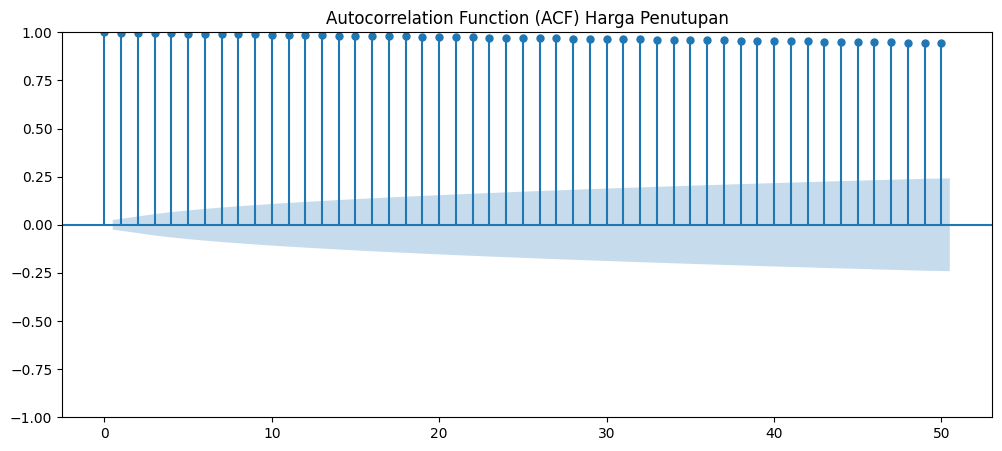

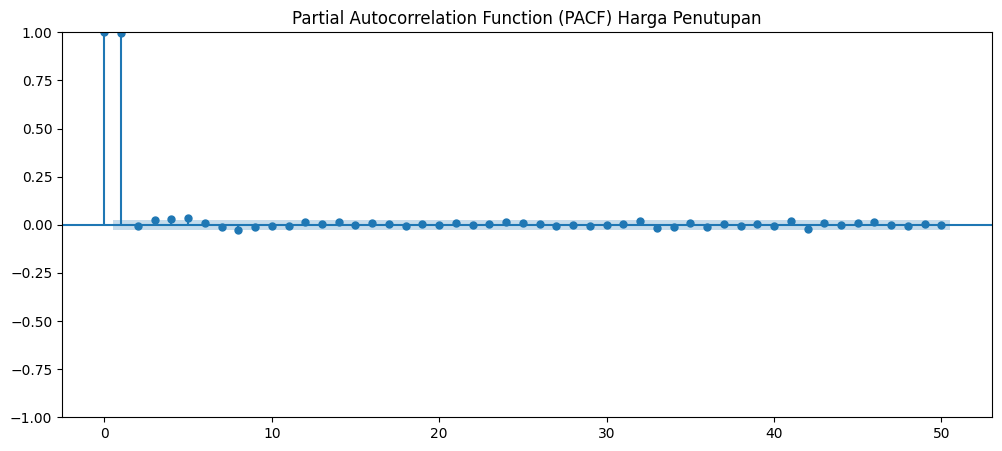

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(gold['close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Harga Penutupan')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(gold['close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) Harga Penutupan')
plt.show()

### 📈 Analisis Autocorrelation Function (ACF) Harga Penutupan Logam Mulia

### 1. Korelasi Otokorelasi yang Sangat Tinggi
- Grafik menunjukkan bahwa **nilai ACF sangat tinggi (mendekati 1)** untuk semua lag hingga 50 hari.
- Ini mengindikasikan bahwa **harga penutupan hari ini sangat bergantung pada harga-harga sebelumnya** — terdapat **autokorelasi kuat** dalam data.

### 2. Tidak Ada Pemotongan Tajam (Cut-off)
- Tidak terlihat adanya penurunan cepat menuju nol atau osilasi bolak-balik (yang biasanya terjadi pada proses white noise atau ARMA).
- Hal ini mengisyaratkan bahwa data kemungkinan **non-stationary**, karena tren yang kuat menyebabkan korelasi tinggi terus berlanjut pada lag yang panjang.

### 3. Potensi Adanya Tren Jangka Panjang
- ACF seperti ini umum terjadi pada **data harga keuangan dengan tren**, seperti logam mulia, saham, atau indeks.
- **Model prediktif berbasis deret waktu (seperti ARIMA)** perlu melakukan transformasi data (misalnya differencing) agar stasioner sebelum digunakan untuk pemodelan.

---

### ✅ Kesimpulan
- Data harga penutupan logam mulia menunjukkan **autokorelasi yang sangat kuat**, menunjukkan ketergantungan jangka panjang dan adanya tren.
- **Data belum stasioner**, sehingga perlu dilakukan **differencing** atau transformasi lainnya sebelum digunakan dalam model deret waktu seperti ARIMA atau SARIMA.
- ACF ini menguatkan temuan pada analisis tren sebelumnya — bahwa harga bergerak dengan arah tertentu dan tidak acak.


## q. Plot return harian sepanjang waktu (volatility)

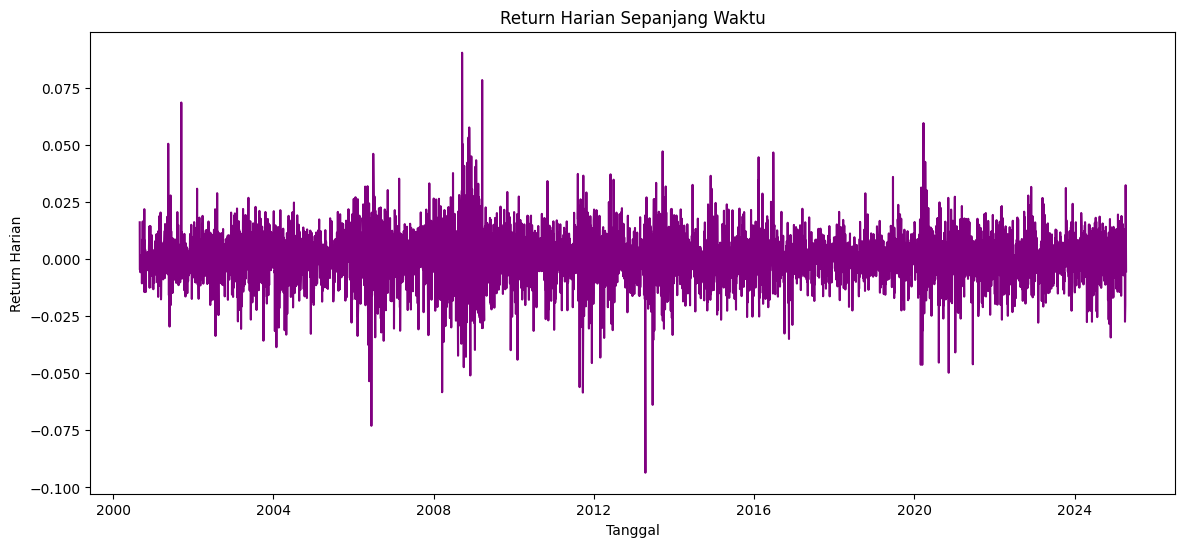

In [38]:
plt.figure(figsize=(14,6))
plt.plot(gold['daily_return'], color='purple')
plt.title('Return Harian Sepanjang Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Return Harian')
plt.show()

### 📊 Analisis Return Harian Harga Logam Mulia (2000–2025)

### 1. Distribusi Return Mengelilingi Nol
- Return harian berfluktuasi di sekitar nilai **0**, yang merupakan karakteristik umum aset keuangan.
- Hal ini menunjukkan bahwa **tidak terdapat kecenderungan sistematis** untuk return positif atau negatif dalam jangka pendek.
- Fluktuasi yang acak mengindikasikan bahwa **return harian sulit diprediksi** tanpa model statistik yang lebih kompleks.

### 2. Volatilitas Tidak Konsisten (Volatility Clustering)
- Terlihat jelas adanya **periode dengan volatilitas tinggi**, di mana return harian sangat bervariasi, dan periode lainnya yang lebih stabil.
- Pola ini dikenal sebagai **volatility clustering**, yaitu kecenderungan volatilitas tinggi diikuti oleh volatilitas tinggi, dan sebaliknya.
- Periode dengan volatilitas tinggi antara lain:
  - Sekitar **2008–2011**, yang sesuai dengan **krisis keuangan global**.
  - Tahun **2020**, saat terjadi **ketidakpastian ekonomi akibat pandemi COVID-19**.

### 3. Pergerakan Ekstrem (Outliers)
- Beberapa titik return harian menunjukkan perubahan ekstrem (baik positif maupun negatif), seperti lonjakan di atas **0.08** atau penurunan tajam di bawah **-0.08**.
- Outlier ini biasanya berkaitan dengan **berita besar**, **kejadian geopolitik**, atau **intervensi pasar**.

---

### ✅ Kesimpulan
- Return harian logam mulia menunjukkan perilaku yang **volatil dan tidak stabil**, dengan fluktuasi acak yang mengelilingi nilai nol.
- **Volatility clustering** dan kehadiran **outlier** menandakan bahwa model statistik seperti **GARCH** dapat lebih tepat digunakan untuk memodelkan dinamika volatilitas.
- Investor perlu mempertimbangkan **risiko jangka pendek yang tinggi**, meskipun tren jangka panjang logam mulia cenderung positif.


## r. Visualisasi outlier dengan boxplot return harian

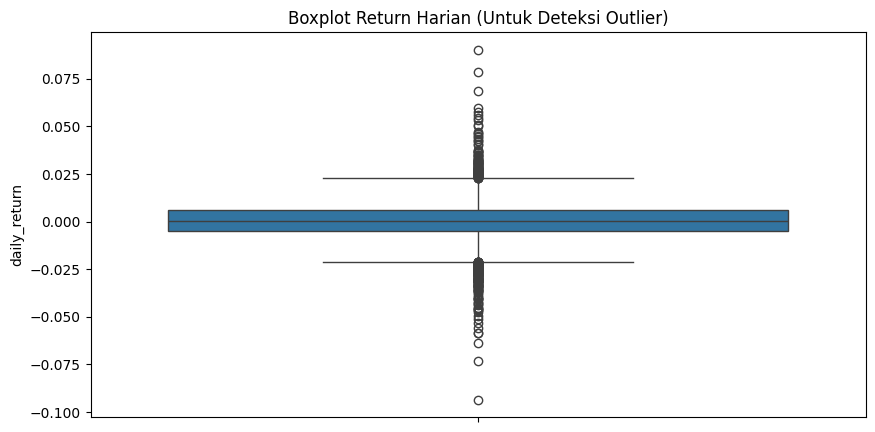

In [39]:
plt.figure(figsize=(10,5))
sns.boxplot(gold['daily_return'].dropna())
plt.title('Boxplot Return Harian (Untuk Deteksi Outlier)')
plt.show()

### 📦 Analisis Boxplot Return Harian Logam Mulia (Deteksi Outlier)

### 1. Persebaran Return Harian
- Mayoritas return harian berada di sekitar nilai **0**, menunjukkan bahwa sebagian besar perubahan harga harian logam mulia bersifat kecil dan stabil.
- Nilai median return berada sangat dekat dengan nol, menunjukkan **simetri** dalam distribusi return.

### 2. Rentang Interkuartil (IQR)
- **Box (kotak)** mewakili rentang interkuartil (antara Q1 dan Q3), yaitu 50% nilai return harian.
- Rentang IQR cukup sempit, menunjukkan bahwa fluktuasi normal harian biasanya kecil.

### 3. Outlier Ekstrem
- Titik-titik di luar garis "whiskers" (jangkauan normal data) merupakan **outlier** — yaitu perubahan harga harian yang tidak biasa.
- Terdapat banyak **outlier positif dan negatif**, mencerminkan:
  - **Peristiwa pasar ekstrem**, seperti krisis keuangan, pandemi, atau intervensi pemerintah.
  - Potensi **volatilitas tinggi pada hari-hari tertentu**.

### 4. Implikasi terhadap Risiko
- Kehadiran outlier dalam jumlah signifikan menunjukkan bahwa pasar logam mulia memiliki **fat tails** (ekor distribusi yang tebal).
- Ini menandakan bahwa kejadian ekstrem lebih sering terjadi dibandingkan asumsi distribusi normal, yang penting untuk:
  - **Manajemen risiko**
  - **Perhitungan Value-at-Risk (VaR)**
  - **Pemodelan distribusi return dengan pendekatan non-parametrik atau distribusi heavy-tailed seperti t-distribution**

---

### ✅ Kesimpulan
- Return harian logam mulia umumnya stabil, namun terdapat cukup banyak **outlier ekstrem**.
- Boxplot ini mengonfirmasi bahwa risiko kejadian langka namun berdampak besar perlu diperhitungkan dalam strategi investasi dan manajemen portofolio.


## s. Word Cloud dari kolom headlines

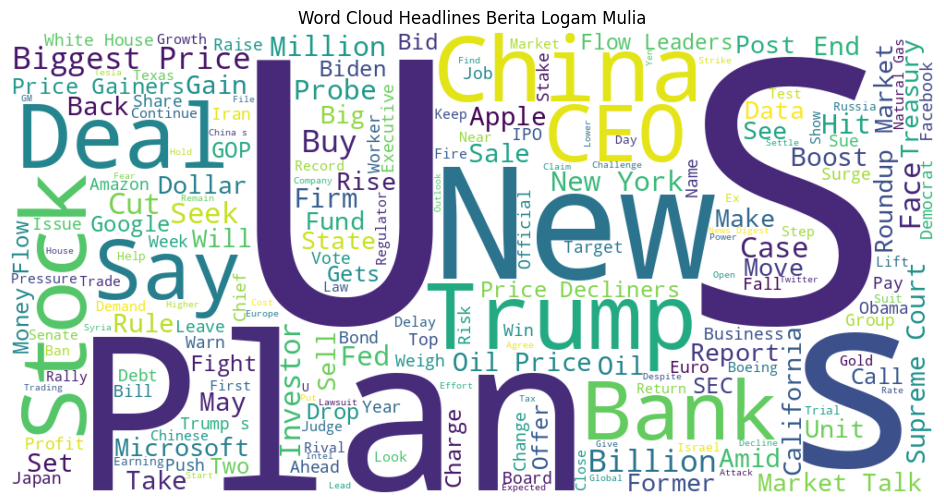

In [40]:
text = ' '.join(gold['headlines'].dropna().astype(str))

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Headlines Berita Logam Mulia')
plt.show()


### ☁️ Analisis Word Cloud dari Berita Logam Mulia

### 1. Kata-Kata Paling Dominan
- Kata-kata yang paling menonjol dalam word cloud antara lain:
  - **"News"**, **"US"**, **"Plan"**, **"Deal"**, **"Trump"**, **"Bank"**, **"Stock"**, dan **"Price"**.
- Ini menunjukkan bahwa berita logam mulia seringkali berkaitan dengan isu-isu ekonomi makro dan geopolitik global.

### 2. Pengaruh Politik dan Ekonomi Global
- Kata **"Trump"**, **"China"**, dan **"Biden"** mencerminkan pengaruh kuat dari kebijakan pemerintah dan ketegangan geopolitik terhadap pasar logam mulia.
- Kata **"Bank"**, **"Investor"**, dan **"Debt"** menunjukkan perhatian pasar terhadap kebijakan moneter dan sektor keuangan.

### 3. Fokus pada Pasar dan Harga
- Kehadiran kata **"Price"**, **"Stock"**, **"Market"**, dan **"Oil"** menegaskan bahwa berita yang berkaitan dengan pergerakan harga dan pasar komoditas sangat relevan terhadap dinamika logam mulia.
- Kata **"Gold"** juga muncul, mengindikasikan hubungan langsung antara berita dan instrumen logam mulia tersebut.

### 4. Aktivitas Korporat dan Eksekutif
- Kata-kata seperti **"CEO"**, **"Microsoft"**, **"Apple"**, dan **"Firm"** menunjukkan bahwa berita korporat dan pernyataan eksekutif juga berpengaruh pada sentimen pasar logam mulia.

---

### ✅ Kesimpulan
- Word cloud ini mengilustrasikan bahwa sentimen dan headline berita mengenai logam mulia banyak dipengaruhi oleh:
  - Faktor makroekonomi (bank, utang, harga minyak)
  - Isu geopolitik dan politik (AS, China, Trump, Biden)
  - Berita korporat dan eksekutif besar (CEO, Apple, Microsoft)
- Investor dapat memanfaatkan analisis headline ini sebagai **indikator sentimen pasar** untuk memperkirakan arah pergerakan logam mulia.


## t. Analisis panjang teks headlines

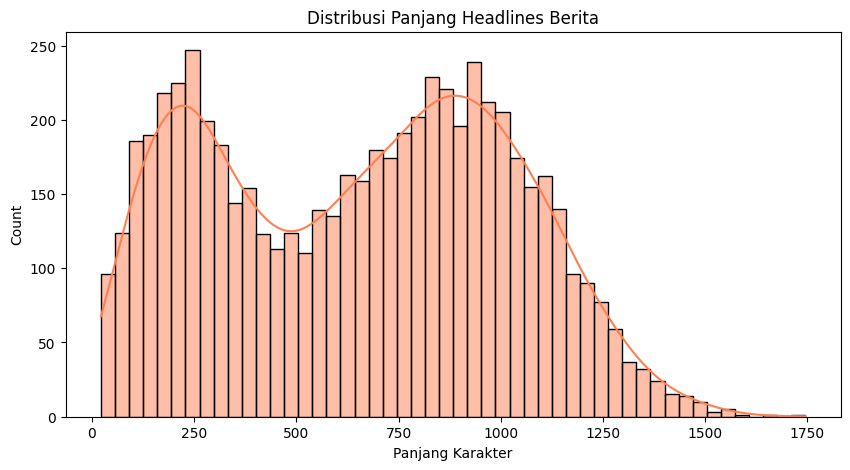

In [41]:
gold['headline_length'] = gold['headlines'].fillna('').apply(len)

plt.figure(figsize=(10,5))
sns.histplot(gold['headline_length'], bins=50, kde=True, color='coral')
plt.title('Distribusi Panjang Headlines Berita')
plt.xlabel('Panjang Karakter')
plt.show()

### ☁️ Analisis Word Cloud dari Berita Logam Mulia

### 1. Kata-Kata Paling Dominan
- Kata-kata yang paling menonjol dalam word cloud antara lain:
  - **"News"**, **"US"**, **"Plan"**, **"Deal"**, **"Trump"**, **"Bank"**, **"Stock"**, dan **"Price"**.
- Ini menunjukkan bahwa berita logam mulia seringkali berkaitan dengan isu-isu ekonomi makro dan geopolitik global.

### 2. Pengaruh Politik dan Ekonomi Global
- Kata **"Trump"**, **"China"**, dan **"Biden"** mencerminkan pengaruh kuat dari kebijakan pemerintah dan ketegangan geopolitik terhadap pasar logam mulia.
- Kata **"Bank"**, **"Investor"**, dan **"Debt"** menunjukkan perhatian pasar terhadap kebijakan moneter dan sektor keuangan.

### 3. Fokus pada Pasar dan Harga
- Kehadiran kata **"Price"**, **"Stock"**, **"Market"**, dan **"Oil"** menegaskan bahwa berita yang berkaitan dengan pergerakan harga dan pasar komoditas sangat relevan terhadap dinamika logam mulia.
- Kata **"Gold"** juga muncul, mengindikasikan hubungan langsung antara berita dan instrumen logam mulia tersebut.

### 4. Aktivitas Korporat dan Eksekutif
- Kata-kata seperti **"CEO"**, **"Microsoft"**, **"Apple"**, dan **"Firm"** menunjukkan bahwa berita korporat dan pernyataan eksekutif juga berpengaruh pada sentimen pasar logam mulia.

---

### ✅ Kesimpulan
- Word cloud ini mengilustrasikan bahwa sentimen dan headline berita mengenai logam mulia banyak dipengaruhi oleh:
  - Faktor makroekonomi (bank, utang, harga minyak)
  - Isu geopolitik dan politik (AS, China, Trump, Biden)
  - Berita korporat dan eksekutif besar (CEO, Apple, Microsoft)
- Investor dapat memanfaatkan analisis headline ini sebagai **indikator sentimen pasar** untuk memperkirakan arah pergerakan logam mulia.
